In [1]:
using MPI
using CLIMA
using Logging
using CLIMA.Mesh.Topologies
using CLIMA.Mesh.Grids
using CLIMA.Mesh.Elements: interpolationmatrix
using CLIMA.DGmethods
using CLIMA.DGmethods.NumericalFluxes
using CLIMA.MPIStateArrays
using CLIMA.LowStorageRungeKuttaMethod
using LinearAlgebra
using CLIMA.GenericCallbacks: EveryXWallTimeSeconds, EveryXSimulationSteps
using CLIMA.ODESolvers
ENV["GKS_ENCODING"] = "utf-8"
using Plots
gr()

Plots.GRBackend()

In [2]:
CLIMA.init()

In [3]:
include("soilmodel.jl")

boundary_state! (generic function with 11 methods)

In [4]:
# set up domain
# this is using 5 vertical elements, each with a 5th degree polynomial, 
# giving an approximate resolution of 5cm
const velems = 0.0:-0.2:-1
const N = 5
topl = StackedBrickTopology(MPI.COMM_WORLD, (0.0:1,0.0:1,velems); 
    periodicity = (true,true,false),
    boundary=((0,0),(0,0),(1,2)))
grid = DiscontinuousSpectralElementGrid(topl, FloatType = Float64, DeviceArray = Array, polynomialorder = N)

m = SoilModel(initialT=10)

# Set up DG scheme
dg = DGModel( # 
  m, # "PDE part"
  grid,
  CentralNumericalFluxNonDiffusive(), # penalty terms for discretizations
  CentralNumericalFluxDiffusive(),
  CentralNumericalFluxGradient())

Δ = min_node_distance(grid)
CFL_bound = (Δ^2 / (2m.λ/(m.ρc)))
dt = CFL_bound*0.5 # TODO: provide a "default" timestep based on  Δx,Δy,Δz


141.9891653167154

In [5]:
const minute = 60
const hour = 60*minute
const day = 24*hour

function plotstate(grid, Q)
    # TODO:
    # this currently uses some internals: provide a better way to do this
    gridg = reshape(grid.vgeo[(1:(N+1)^2:(N+1)^3),CLIMA.Mesh.Grids.vgeoid.x3id,:],:)*100
    Tg = reshape(Q.data[(1:(N+1)^2:(N+1)^3),1,:],:) ./ m.ρc
    plot(Tg, gridg, ylabel="depth (cm)", xlabel="T (°C)", yticks=-100:20:0, xlimits=(0,20), legend=false)
end

plotstate (generic function with 1 method)

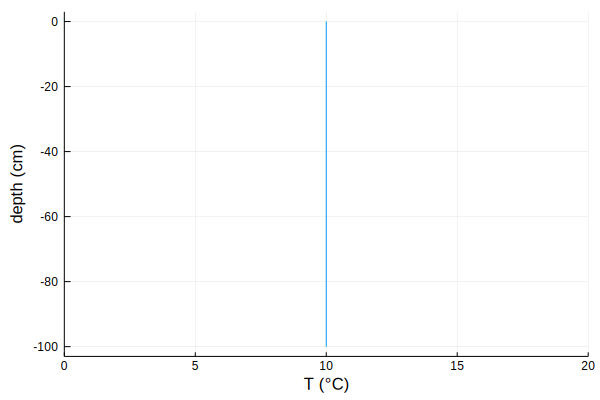

In [6]:
# state variable
Q = init_ode_state(dg, Float64(0))

# initialize ODE solver
lsrk = LSRK54CarpenterKennedy(dg, Q; dt = dt, t0 = 0)
plotstate(grid, Q)

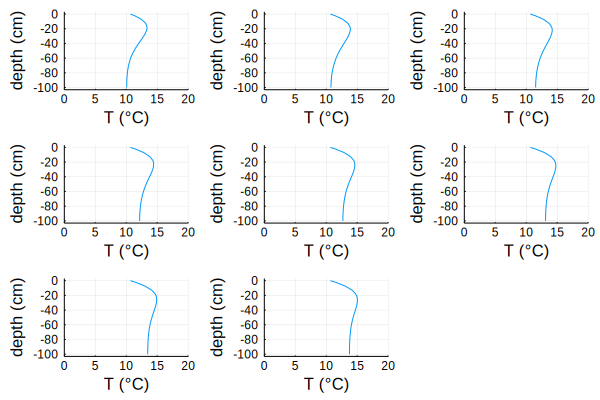

In [7]:
# run for 8 days to get to steady state
plots = Any[]
for i = 1:8
    t = solve!(Q, lsrk; timeend=i*day)
    push!(plots, plotstate(grid, Q))
end
plot(plots...)

In [8]:
# a function for performing interpolation on the DG grid
# TODO: use CLIMA interpolation once available
function interpolate(grid, Q, Zprofile)
    P = zeros(size(Zprofile))
    nelems = size(grid.vgeo, 3)
    for elem in 1:nelems
        G = grid.vgeo[(1:(N+1)^2:(N+1)^3),CLIMA.Mesh.Grids.vgeoid.x3id,elem]
        I = minimum(G) .< Zprofile .<= maximum(G)
        M = interpolationmatrix(G, Zprofile[I])
        P[I] .= M*Q.data[(1:(N+1)^2:(N+1)^3),1,elem]
    end
    return P
end

interpolate (generic function with 1 method)

In [9]:
Zprofile = -0.995:0.01:0 # needs to be in sorted order for contour function
Tprofile = zeros(length(Zprofile),24)
hours = 0.5:1:24

for (i,h) in enumerate(hours)
    t = solve!(Q, lsrk; timeend=21*day+h*hour)
    Tprofile[:,i] = interpolate(grid, Q, Zprofile) ./ m.ρc
end


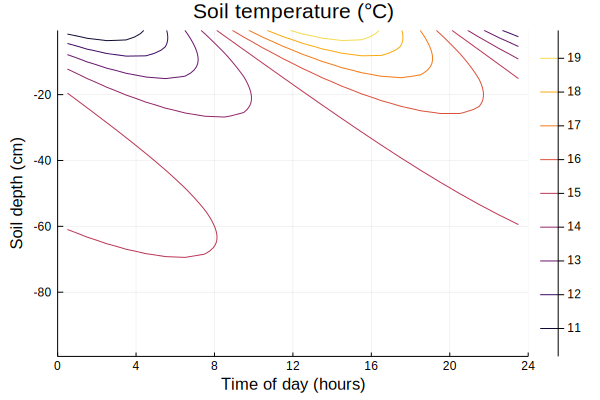

In [10]:
contour(hours, Zprofile.*100, Tprofile, 
    levels=10:20, xticks=0:4:24, xlimits=(0,24), 
    xlabel="Time of day (hours)", ylabel="Soil depth (cm)", title="Soil temperature (°C)")